# Notebook Usage

1. Add `-DENABLE_PROFILING=ON` when pass args to Cmake. And then do the normal `make` process.

2. Comment out anything you are not interested in `dlrm_perf_schedule` below. Just comment the event label line, don't comment out
the `forward_events`, `backward_events` or `BottomMLP.fc1` line. You can check for all labels in the cpp code. And also you can add
your own label and recompile it, then insert correspond label in `dlrm_perf_schedule`.

3. Run the cell one by one and follow the instruction in each cell.

4. Should you have any question, please contact Randy Wang(ruotongw@nvidia.com).

In [22]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 1000px; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import sys
import os
from datetime import datetime
from shutil import copy
import json

from IPython.display import display

project_root = os.path.join(os.path.abspath(''), '..', '..')
sys.path.append(project_root)

from tools.profiler import generate_schedule, parse_result
from tools.profiler.chart import timeline_chart, scaling_chart

dlrm_perf_schedule = {
    # interested event name
    'BottomMLP.fc1': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'BottomMLP.fc2': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'BottomMLP.fc3': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'sparse_embedding1': {
        'forward_events': [
            'localized_slot_sparse_embedding_one_hot.forward.mapping_and_fuse'
        ],
        'backward_events': []
    },
    'interaction1': {
        'forward_events': [],
        'backward_events': []
    },
    'TopMLP.fc4': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc5': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc6': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc7': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
            'fused_relu_bias_fully_connected.bprop.initialize_array',
            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_relu_bias_fully_connected.bprop.convert_array',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc8': {
        'forward_events': [
            'fully_connected_layer_half.fprop',
            'fully_connected_layer_half.fprop.cublasGemmEx_1',
            'fully_connected_layer_half.fprop.cublasGemmEx_2'
        ],
        'backward_events': [
            'fully_connected_layer_half.bprop',
            'fully_connected_layer_half.bprop.cublasGemmEx_1',
            'fully_connected_layer_half.bprop.cublasGemmEx_2',
            'fully_connected_layer_half.bprop.cublasGemmEx_3'
        ]
    },
}

In [23]:
# Define profiling_dir for this profiling session.
# Specify the config file you want to use. Also other configs, like slurm related.
working_dir = os.path.join('tools', 'profiler')
# train configs
config_name = '55296_8gpus'
config_file = os.path.join('mlperf', 'configs', config_name + '.json')
# slurm related
nodes_num = 1
container_name = 'hugectr-dlrm-profiling'
image = 'gitlab-master.nvidia.com/dl/mlperf/optimized:recommendation.hugectr.2035814'
mounts_str = '/raid:/raid,/lustre/fsw/mlperft-dlrm/ruotongw/hugectr:/etc/workspace/home'
account = 'mlperft-dlrm'
jobid = '1069007'
# profiler related
profiling_dir_name = 'dgxa100_{nodes_num}node_'.format(nodes_num=nodes_num) + config_name
profiling_dir = os.path.join(working_dir, 'results', profiling_dir_name)

In [26]:
# create if profiling_dir non-exist.
os.makedirs(os.path.join(project_root, profiling_dir), exist_ok=True)
# Copy config to profiling_dir, for backup
copy(os.path.join(project_root, config_file), os.path.join(project_root, profiling_dir))
# Create a prof.schedule in profiling_dir. This file will instruct cpp profiler how to prof. 
generate_schedule(dlrm_perf_schedule, os.path.join(project_root, profiling_dir))

## Run the training

You may want to first
```
salloc -p luna -A {account} -N{nodes_num} bash
```
to apply for resources in advance. Remeber the jobid and fill in above.

The hugectr will exit after the profiling is completed, usually only run for 1000 - 3000 iters, depends on how many
interested events you defined in the dlrm_perf_schedule. The raw result will appear in profiling_dir as ${host_name}.prof.json.
If you use multiple nodes, there will be several jsons appear. The result json is not human readable, so please use function below to parse it.

In [30]:
cmd = '''
    srun --mpi=pmix --ntasks="{nodes_num}" --ntasks-per-node=1 --container-workdir /etc/workspace/home \\
         --container-name="{container_name}" --container-mounts="{mounts_str}" --container-image={image} \\
         --export=NCCL_LAUNCH_MODE=PARALLEL,PROFILING_DIR={profiling_dir} -A {account} --jobid={jobid}\\
         numactl --interleave=all ./build/bin/huge_ctr --train {config_file}
'''.format(mounts_str=mounts_str, nodes_num=nodes_num, image=image, container_name=container_name,
           profiling_dir=profiling_dir, config_file=config_file, account=account, jobid=jobid)
print(cmd)
!$cmd


    srun --mpi=pmix --ntasks="1" --ntasks-per-node=1 --container-workdir /etc/workspace/home \
         --container-name="hugectr-dlrm-profiling" --container-mounts="/raid:/raid,/lustre/fsw/mlperft-dlrm/ruotongw/hugectr:/etc/workspace/home" --container-image=gitlab-master.nvidia.com/dl/mlperf/optimized:recommendation.hugectr.2035814 \
         --export=NCCL_LAUNCH_MODE=PARALLEL,PROFILING_DIR=tools/profiler/results/dgxa100_1node_55296_8gpus -A mlperft-dlrm --jobid=1069007\
         numactl --interleave=all ./build/bin/huge_ctr --train mlperf/configs/55296_8gpus.json

/bin/bash: line 1: srun: command not found


## Result

The hugectr will exit after the profiling is completed, usually only run for 1000 - 3000 iters, depends on how many
interested events you defined in the `dlrm_perf_schedule`. The raw result will appear in `profiling_dir` as
`${host_name}.prof.json`. If you use multiple nodes, there will be several jsons appear. The result json is not
human readable, so please use function below to parse it.

In [33]:
# Parse the result into more human readable format.
result = parse_result(os.path.join(project_root, profiling_dir))
# print adn save the result
with open(os.path.join(project_root, profiling_dir, profiling_dir_name + '.json'), 'w') as f:
    json.dump(result, f, indent=2)
print(json.dumps(result, indent=2))
# And you can do anything you like, for instance drawing all kinds of chart from the result

[
  {
    "host_name": "luna-0027",
    "avg_iter_time_ms": 2.312174269556999,
    "timeline": {
      "device_0": {
        "stream_0": [
          {
            "label": "BottomMLP.fc1.fused_relu_bias_fully_connected.fprop",
            "avg_measured_time_ms": 0.036126719936728474,
            "avg_iter_start_to_event_start_time_ms": 0.4983795201778412
          },
          {
            "label": "BottomMLP.fc3.fused_relu_bias_fully_connected.fprop",
            "avg_measured_time_ms": 0.023876480013132095,
            "avg_iter_start_to_event_start_time_ms": 0.535159040093422
          },
          {
            "label": "BottomMLP.fc2.fused_relu_bias_fully_connected.fprop",
            "avg_measured_time_ms": 0.021503359973430634,
            "avg_iter_start_to_event_start_time_ms": 0.5375327962636948
          },
          {
            "label": "TopMLP.fc4.fused_relu_bias_fully_connected.fprop",
            "avg_measured_time_ms": 0.04435967974364757,
            "avg_iter_start

In [ ]:
# Draw a timeline chart
timeline_chart(result)

<IPython.core.display.Javascript object>


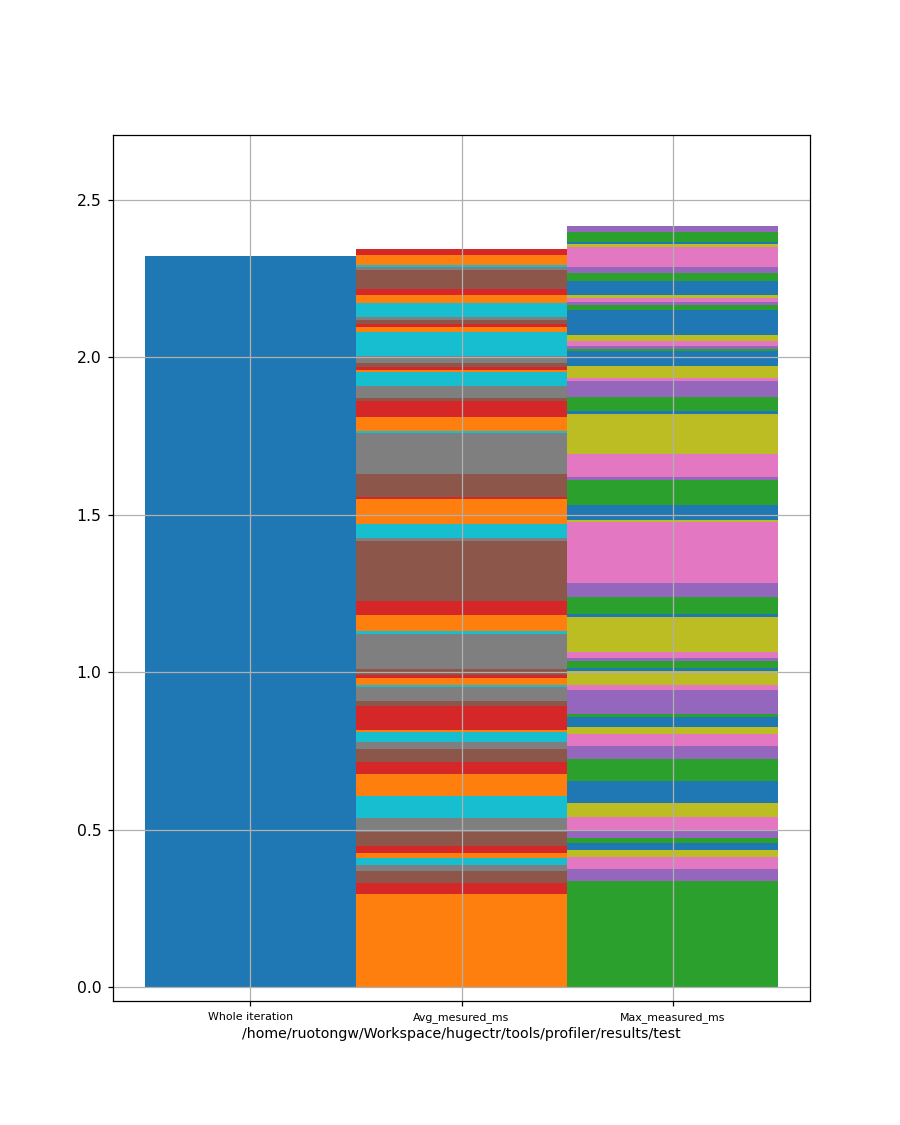

[1.1 1.3 1.5]


In [18]:
#profiling_dirs = ['dgxA100-1node-batch55k', 'dgxA100-2node-batch55k', 'dgxA100-4node-batch55k']
profiling_dirs = [profiling_dir]
results = []
names = []
for prof_dir in profiling_dirs:
    names.append(prof_dir)
    results.append(parse_result(prof_dir))
    
# draw scaling chart
scaling_chart(results, names)